In [4]:
from langgraph.graph import StateGraph,START,END
from langchain_core.messages import BaseMessage,HumanMessage,SystemMessage
from langchain_groq import ChatGroq
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import DirectoryLoader,PyPDFLoader
from langchain_community.vectorstores import FAISS
from dotenv import load_dotenv
load_dotenv()
import os

from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain.prompts import PromptTemplate

In [5]:
from typing import TypedDict,Annotated
from langchain_core.documents import Document
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langgraph.graph.message import add_messages

class AgenticRAG(TypedDict):
    query:str
    documents_path:str
    documents:list[Document]
    chunks:list[Document]
    vectorstore:object
    retrieved_docs:list[Document]
    answer:str
    vectorstore_path:str
    messages: Annotated[list[BaseMessage], add_messages]

In [6]:
from langchain_core.prompts import PromptTemplate
prompt_template = PromptTemplate(template = """
You are a helpful assistant.
Here is past conversation:
{history}

Here are the relevant documents:
{context}

Now answer the user's question:
{question}
""",
input_variables=["context", "question","history"]
)



In [7]:
model = ChatGroq(model="Llama-3.3-70B-Versatile")

In [ ]:
from tqdm import tqdm

EMBEDDER = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

def Document_Loader(state: AgenticRAG):
    path = os.path.abspath(state["documents_path"])  # ensure absolute
    if os.path.isfile(path):  # single PDF case
        loader = PyPDFLoader(path)
        loaded_pdf = loader.load()
    elif os.path.isdir(path):  # directory case
        loader = DirectoryLoader(
            path=path,
            glob="*.pdf",
            loader_cls=PyPDFLoader)
        loaded_pdf = loader.load()
    else:
        raise ValueError(f"Invalid documents_path: {path}")
    return {"documents": loaded_pdf}



def Text_Splitter(state:AgenticRAG):
    splitter = RecursiveCharacterTextSplitter(chunk_size=1000,chunk_overlap=199)
    chunks = splitter.split_documents(state["documents"])
    return {"chunks":chunks}

def Create_Vector_Store(state:AgenticRAG):
    embedder = EMBEDDER
    vector_store = FAISS.from_documents(documents=state["chunks"],embedding=embedder)
    vector_store.save_local(state["vectorstore_path"])

    return {"vectorstore_path":state["vectorstore_path"]}


def Load_Vector_Store(state:AgenticRAG):
    embedder = EMBEDDER
    vector_store = FAISS.load_local(folder_path=state["vectorstore_path"],
                                    embeddings=embedder,
                                    allow_dangerous_deserialization=True)
    return {"vectorstore_path":state["vectorstore_path"]}


def Retriever(state: AgenticRAG):
    vector_store = FAISS.load_local(
        folder_path=state["vectorstore_path"],
        embeddings=EMBEDDER,
        allow_dangerous_deserialization=True)
    retriever = vector_store.as_retriever()
    
    query = state["query"]

    docs = retriever.invoke(query)
    return {"retrieved_docs": docs}


# Conversation Buffer Memory

Conversation buffer memory will work within the session (until restart).

In [9]:
from langchain_core.chat_history import InMemoryChatMessageHistory
from langchain.memory import ConversationBufferMemory


chat_history = InMemoryChatMessageHistory()

# Create memory object
memory = ConversationBufferMemory( 
    memory_key="chat_history",
    chat_memory=chat_history,
    return_messages=True)



def Agent(state:AgenticRAG):
    docs = state["retrieved_docs"]
    context = "\n\n".join([doc.page_content for doc in docs])

    # Build chat history string
    past_dialogue = "\n".join([
            f"User: {msg.content}" if msg.type == "human" else f"Bot: {msg.content}"
            for msg in memory.chat_memory.messages])
    
    formated_prompt = prompt_template.format(
        history=past_dialogue,
        context = context,
        question = state["query"])
    
    response = model.invoke(formated_prompt)

    #save to memory
    memory.chat_memory.add_user_message(state["query"])
    memory.chat_memory.add_ai_message(response.content)
    
    return{"answer":response.content,
            "messages": [AIMessage(content=response.content)]}


def check_pdf_or_not(state: AgenticRAG):
    if state.get("documents_path") and not os.path.exists(state["vectorstore_path"]):
        return "create"
    else:
        return "load"

C:\Users\hasee\AppData\Local\Temp\ipykernel_6984\4292910918.py:8: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  memory = ConversationBufferMemory(


## StateGraph

In [10]:
from langgraph.checkpoint.sqlite import SqliteSaver
import sqlite3

db_path = os.path.abspath("./chat_hist/chat.db")
os.makedirs(os.path.dirname(db_path), exist_ok=True)
conn = sqlite3.connect(database=db_path, check_same_thread=False)
checkpointer = SqliteSaver(conn=conn)

graph = StateGraph(AgenticRAG)

graph.add_node("Document_Loader",Document_Loader,)
graph.add_node("Text_Splitter",Text_Splitter)
graph.add_node("Create_Vector_Store",Create_Vector_Store)
graph.add_node("Load_Vector_Store",Load_Vector_Store)  
graph.add_node("Retriever",Retriever)
graph.add_node("Agent",Agent)

graph.add_conditional_edges(START,check_pdf_or_not,{"create":"Document_Loader",
                                                    "load":"Load_Vector_Store"})


# If new Vectorstore
graph.add_edge("Document_Loader","Text_Splitter")
graph.add_edge("Text_Splitter","Create_Vector_Store")
graph.add_edge("Create_Vector_Store","Retriever")

# if Loading VectorStore
graph.add_edge("Load_Vector_Store","Retriever")

graph.add_edge("Retriever", "Agent")
graph.add_edge("Agent", END)

app = graph.compile(checkpointer=checkpointer)

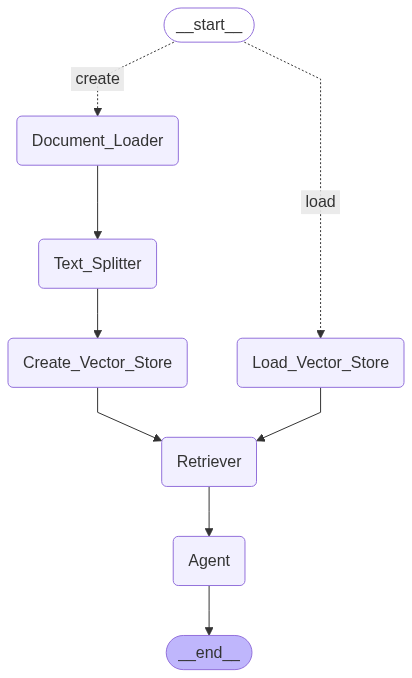

In [18]:
from IPython.display import display,Image
display(Image(app.get_graph().draw_mermaid_png()))

## ConversationBufferMemory

In [13]:
CONFIG = {"configurable":{"thread_id":"1"}}
while True:
    query = input("Enter your query (or type 'exit' to quit): ")

    if query.lower() in ["exit", "bye", "close"]:
        print("Exiting...")
        break

    user_input = {
        "vectorstore_path": "../vectorstores/legal_faiss",  
        "query": query}

    result = app.invoke(user_input,config=CONFIG)
    print("Query:", user_input["query"])
    print("Answer:", result["answer"])

Query: power of president
Answer: The conversation provided doesn't seem to be related to the power of a president. The text appears to be discussing Islamic Sharia Law and the concept of intention behind actions. It also mentions differences of opinion among scholars on certain points.

If you're looking for information on the power of a president, I'd be happy to provide general information on the topic. The powers of a president can vary depending on the country and its constitution. In general, a president's powers may include:

* Executive authority: The president serves as the head of the executive branch of government and is responsible for enforcing laws and policies.
* Legislative authority: In some countries, the president has the power to propose legislation, veto laws, or call special sessions of the legislature.
* Diplomatic authority: The president represents the country internationally and has the power to negotiate treaties, receive foreign dignitaries, and appoint amba